<h1><span style="background-color:blue; color:white; padding: 5px;">Entrainment de modèles avec RandomForest Regressor<br></h1>
</h4><span style="background-color:red; color:white; padding: 5px;">Utiliser un outil permettant de rafraîchir la page régulièrement pour éviter la mise en sommeil de MLflow sur Heroku
</span></h4>

In [1]:
import pandas as pd
from functions2 import *

### Choix du type de bien à entraîner

In [2]:
type_de_bien = "Maison"

### Chargement des données

In [3]:
query=f"""
SELECT 
    V.SURFACE_BATI,
    V.DEPENDANCES,
    V.ID_COMMUNE,
    R.Name_region,
    {'V.SURFACE_TERRAIN,' if type_de_bien=="Maison" else ''}
    V.DATE_MUTATION,
    V.MONTANT
FROM VENTES V
INNER JOIN TYPES_BIENS as T ON V.ID_TYPE_BIEN = T.ID_TYPE_BIEN
INNER JOIN COMMUNES AS C ON V.ID_COMMUNE = C.ID_COMMUNE
INNER JOIN DEPARTEMENTS AS D ON C.ID_DEPT = D.ID_DEPT
INNER JOIN REGIONS R ON D.ID_REGION = R.ID_REGION
WHERE V.MONTANT>15000
AND V.MONTANT<6500000
AND T.NAME_TYPE_BIEN='{type_de_bien}'
AND V.SURFACE_BATI>0
AND V.NB_PIECES>0
# AND V.DATE_MUTATION >= DATE_SUB((SELECT MAX(DATE_MUTATION) FROM VENTES), INTERVAL 15 MONTH)
AND R.Name_region NOT IN("Martinique", "Guyane", "La Réunion", "Mayotte", "Guadeloupe");
"""

df = loading_data(query)
print(f"Les données s'étendent du {df['DATE_MUTATION'].min()} au {df['DATE_MUTATION'].max()}")
print(f"Il y a {df.shape[0]} ventes sur cette durée.")
print("Voici un aperçue des données :")
df.head()

Chargement des données en cours...
Création engine sqlalchemy OK
Chargement des données ok
Les données s'étendent du 2018-07-01 00:00:00 au 2022-12-31 00:00:00
Il y a 2453253 ventes sur cette durée.
Voici un aperçue des données :


,SURFACE_BATI,DEPENDANCES,ID_COMMUNE,Name_region,SURFACE_TERRAIN,DATE_MUTATION,MONTANT
0,170,1,01374,Auvergne-Rhône-Alpes,11578,2018-07-02,360000
1,88,0,02691,Hauts-de-France,71,2018-10-23,33500
2,100,0,16401,Nouvelle-Aquitaine,2003,2018-08-01,115000
3,72,0,02334,Hauts-de-France,659,2018-10-26,42500
4,100,0,16185,Nouvelle-Aquitaine,1754,2018-08-02,117000


### Splittage

In [4]:
X_train,y_train, X_test, y_test = split(df)

Split des données en cours...
Split OK


### Labellisation, standardisation

In [5]:
X_train,X_test,encoders,scalers =  encod_scal(X_train,X_test)

Normalisation des données en cours...
Normalisation des données OK


### Entraînement du modèle

In [6]:
# Configuration du modèle
param_grid = {
    'n_estimators': [50],
    'max_depth': [10],
    'min_samples_split': [2]
    }   
cv=5

In [7]:
model, best_params = train_model_randomforest(X_train,y_train, param_grid, cv)

Entraînement en cours ...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time= 3.8min
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time= 3.8min
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time= 3.8min
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time= 3.9min
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time= 3.9min
Ré-entraînement avec les meilleurs hyperparamètres en cours...
Entraînement OK


### Sauvegarde avec MLflow

In [8]:
# Configuration de mlflow
uri_tracking = "https://mlflowimmoappkevleg-737621d410d0.herokuapp.com/"
experiment_name = "RandomForestRegressor_all_datas_region_time"
run_name = type_de_bien
model_name = f"RFR_all_datas_{type_de_bien}"

Tracé du graphique en cours...


Itération N°1 : train score = 0.7503542167320763 -- validation score = 0.0032559974913527467
Itération N°2 : train score = 0.7383334747791617 -- validation score = -0.007375639151599556
Itération N°3 : train score = 0.7902849251537043 -- validation score = 0.003835366638748061
Itération N°4 : train score = 0.673131150241163 -- validation score = 0.017151438474230063
Itération N°5 : train score = 0.8239704989789232 -- validation score = 0.4149649332961821
Itération N°6 : train score = 0.8507005181889056 -- validation score = 0.47331334690413485
Itération N°7 : train score = 0.8342756250270401 -- validation score = 0.49939786037127165
Itération N°8 : train score = 0.8396347686885298 -- validation score = 0.504279909151039
Itération N°9 : train score = 0.8054808489801923 -- validation score = 0.8019345972538858
Itération N°10 : train score = 0.8463389713067058 -- validation score = 0.8460355970444807


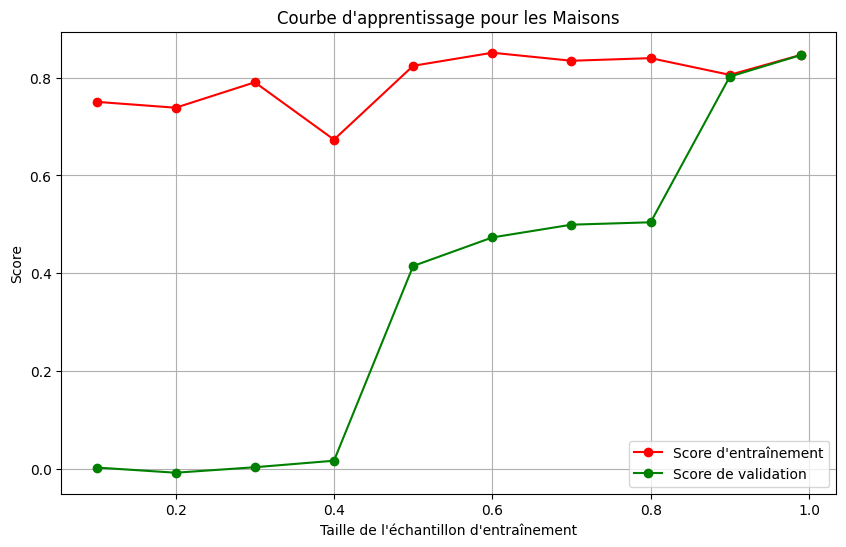

Tracé OK


In [9]:
# Tracé et enregistrement de la learning curve
image_path = plot_learning_curve(RandomForestRegressor(**best_params), run_name, X_train, y_train)

In [10]:
log_mlflow(uri_tracking,
           experiment_name, run_name,
            best_params,
            model, model_name,
            X_test, y_test,
            encoders,scalers,
            image_path)

Log du modèle et des artifacts en cours...


Successfully registered model 'RFR_all_datas_Maison'.
2024/02/13 10:06:23 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: RFR_all_datas_Maison, version 1
Created version '1' of model 'RFR_all_datas_Maison'.


<h2><span style="background-color:red; color:white; padding: 5px;">Entraînement sur 12 mois et test sur les 3derniers mois</span></h2>

Chargement des données en cours...
Création engine sqlalchemy OK
Chargement des données ok
Les données s'étendent du 2021-09-30 00:00:00 au 2022-12-31 00:00:00
Il y a 711111 ventes sur cette durée.
Voici un aperçue des données :
Split des données en cours...
Split OK
Normalisation des données en cours...
Normalisation des données OK
Entraînement en cours ...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time= 3.7min
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time= 3.4min
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time= 3.9min
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time= 4.3min
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time= 3.6min
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time= 6.2min
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time= 6.0min
[CV

2024/02/13 16:01:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: INVALID_PARAMETER_VALUE: The experiment 0 must be in the 'active' state. Current state is deleted.


Ré-entraînement avec les meilleurs hyperparamètres en cours...


2024/02/13 16:08:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: INVALID_PARAMETER_VALUE: The experiment 0 must be in the 'active' state. Current state is deleted.


Entraînement OK
Tracé du graphique en cours...


2024/02/13 16:09:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: INVALID_PARAMETER_VALUE: The experiment 0 must be in the 'active' state. Current state is deleted.


Itération N°1 : train score = 0.878423981779919 -- validation score = 0.534494314077161


2024/02/13 16:11:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: INVALID_PARAMETER_VALUE: The experiment 0 must be in the 'active' state. Current state is deleted.


Itération N°2 : train score = 0.8839642189195666 -- validation score = 0.6026015929432618


2024/02/13 16:14:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: INVALID_PARAMETER_VALUE: The experiment 0 must be in the 'active' state. Current state is deleted.


Itération N°3 : train score = 0.8856733058532766 -- validation score = 0.6470862183594086


2024/02/13 16:17:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: INVALID_PARAMETER_VALUE: The experiment 0 must be in the 'active' state. Current state is deleted.


Itération N°4 : train score = 0.8888514396428573 -- validation score = 0.6956645595529848


2024/02/13 16:21:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: INVALID_PARAMETER_VALUE: The experiment 0 must be in the 'active' state. Current state is deleted.


Itération N°5 : train score = 0.8934450884424789 -- validation score = 0.7339583309226024


2024/02/13 16:26:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: INVALID_PARAMETER_VALUE: The experiment 0 must be in the 'active' state. Current state is deleted.


Itération N°6 : train score = 0.8928641731809693 -- validation score = 0.7704354347576545


2024/02/13 16:31:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: INVALID_PARAMETER_VALUE: The experiment 0 must be in the 'active' state. Current state is deleted.


Itération N°7 : train score = 0.8951451950358567 -- validation score = 0.8051315172740954


2024/02/13 16:40:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: INVALID_PARAMETER_VALUE: The experiment 0 must be in the 'active' state. Current state is deleted.


Itération N°8 : train score = 0.8961255221163391 -- validation score = 0.8350425723194465


2024/02/13 16:49:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: INVALID_PARAMETER_VALUE: The experiment 0 must be in the 'active' state. Current state is deleted.


Itération N°9 : train score = 0.8976186688638637 -- validation score = 0.8664920340139676


2024/02/13 16:58:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: INVALID_PARAMETER_VALUE: The experiment 0 must be in the 'active' state. Current state is deleted.


Itération N°10 : train score = 0.898351999314661 -- validation score = 0.8952542440119237


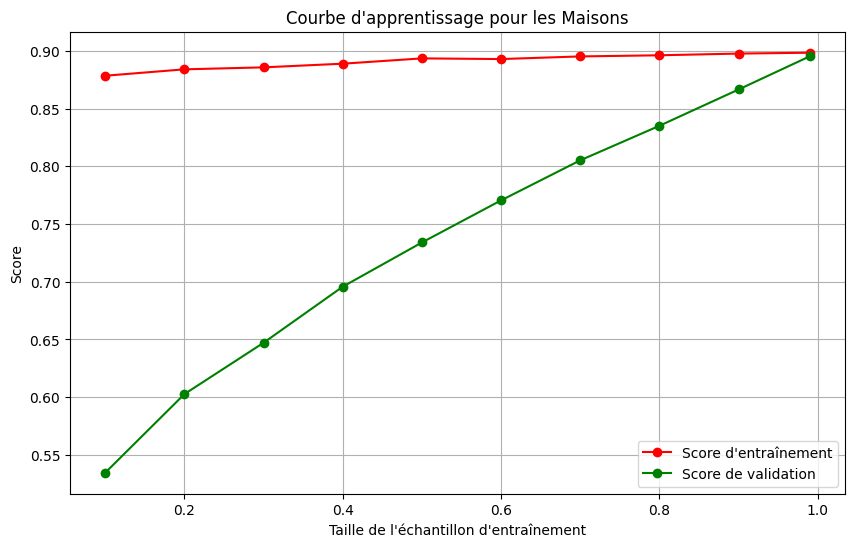

Tracé OK
Log du modèle et des artifacts en cours...


MlflowException: API request to https://mlflowimmoappkevleg-737621d410d0.herokuapp.com/api/2.0/mlflow-artifacts/artifacts/6/a2df7dd220044f1a904445f0c63f69fa/artifacts/ImmoApp/model.pkl failed with exception HTTPSConnectionPool(host='mlflowimmoappkevleg-737621d410d0.herokuapp.com', port=443): Max retries exceeded with url: /api/2.0/mlflow-artifacts/artifacts/6/a2df7dd220044f1a904445f0c63f69fa/artifacts/ImmoApp/model.pkl (Caused by ResponseError('too many 503 error responses'))

In [13]:
# Configuration du modèle
param_grid = {
    'n_estimators': [50,100],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5]
    }   
cv=5

# Configuration de mlflow
uri_tracking = "https://mlflowimmoappkevleg-737621d410d0.herokuapp.com/"
experiment_name = "RandomForestRegressor_15months_all_datas_region"

for type_de_bien in ["Maison","Appartement"] :

    run_name = type_de_bien
    model_name = f"RFR_all_datas_{type_de_bien}"
    
    query=f"""
    SELECT 
        V.SURFACE_BATI,
        V.DEPENDANCES,
        V.ID_COMMUNE,
        R.Name_region,
        {'V.SURFACE_TERRAIN,' if type_de_bien=="Maison" else ''}
        V.DATE_MUTATION,
        V.MONTANT
    FROM VENTES V
    INNER JOIN TYPES_BIENS as T ON V.ID_TYPE_BIEN = T.ID_TYPE_BIEN
    INNER JOIN COMMUNES AS C ON V.ID_COMMUNE = C.ID_COMMUNE
    INNER JOIN DEPARTEMENTS AS D ON C.ID_DEPT = D.ID_DEPT
    INNER JOIN REGIONS R ON D.ID_REGION = R.ID_REGION
    WHERE V.MONTANT>15000  AND V.MONTANT<6500000
    AND T.NAME_TYPE_BIEN='{type_de_bien}'
    AND V.SURFACE_BATI>0
    AND V.NB_PIECES>0
    AND V.DATE_MUTATION >= DATE_SUB((SELECT MAX(DATE_MUTATION) FROM VENTES), INTERVAL 15 MONTH)
    AND R.Name_region NOT IN("Martinique", "Guyane", "La Réunion", "Mayotte", "Guadeloupe");
    """

    df = loading_data(query)
    print(f"Les données s'étendent du {df['DATE_MUTATION'].min()} au {df['DATE_MUTATION'].max()}")
    print(f"Il y a {df.shape[0]} ventes sur cette durée.")
    print("Voici un aperçue des données :")
    
    X_train,y_train, X_test, y_test = split(df)

    X_train,X_test,encoders,scalers =  encod_scal(X_train,X_test)

    model, best_params = train_model_randomforest(X_train,y_train, param_grid, cv)

    # Tracé et enregistrement de la learning curve
    image_path = plot_learning_curve(RandomForestRegressor(**best_params), run_name, X_train, y_train)
    
    log_mlflow(uri_tracking,
           experiment_name, run_name,
            best_params,
            model, model_name,
            X_test, y_test,
            encoders,scalers,
            image_path)

<h2><span style="background-color:red; color:white; padding: 5px;">Un modèle par type de bien en prenant comme paramètre la surface, le prix au m², dépendances et la surface du terrain s'il s'agit d'une maison</span></h2>

In [2]:
# Configuration du modèle
param_grid = {
    'n_estimators': [50,100],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5]
    }   
cv=5

# Configuration de mlflow
uri_tracking = "https://mlflowimmoappkevleg-737621d410d0.herokuapp.com/"
experiment_name = "RandomForestRegressor_m2_all"

# for type_de_bien in ["Maison","Appartement"] :
for type_de_bien in ["Appartement"] :
    run_name = type_de_bien
    model_name = f"RFR_all_datas_{type_de_bien}"

    query=f"""
    SELECT 
        V.SURFACE_BATI,
        V.DEPENDANCES,
        V.ID_COMMUNE,
        R.Name_region,
        {'V.SURFACE_TERRAIN,' if type_de_bien=="Maison" else ''}
        V.DATE_MUTATION,
        V.MONTANT
    FROM VENTES V
    INNER JOIN TYPES_BIENS as T ON V.ID_TYPE_BIEN = T.ID_TYPE_BIEN
    INNER JOIN COMMUNES AS C ON V.ID_COMMUNE = C.ID_COMMUNE
    INNER JOIN DEPARTEMENTS AS D ON C.ID_DEPT = D.ID_DEPT
    INNER JOIN REGIONS R ON D.ID_REGION = R.ID_REGION
    WHERE V.MONTANT>15000  AND V.MONTANT<6500000
    AND T.NAME_TYPE_BIEN='{type_de_bien}'
    AND V.SURFACE_BATI>0
    AND V.NB_PIECES>0
    AND V.DATE_MUTATION >= DATE_SUB((SELECT MAX(DATE_MUTATION) FROM VENTES), INTERVAL 15 MONTH)
    AND R.Name_region NOT IN("Martinique", "Guyane", "La Réunion", "Mayotte", "Guadeloupe");
    """

    df = loading_data(query)
        
    X_train,y_train, X_test, y_test = split_with_m2(df)

    X_train,X_test,encoders,scalers =  encod_scal(X_train,X_test)

    model, best_params = train_model_randomforest(X_train,y_train, param_grid, cv)

    # Tracé et enregistrement de la learning curve
    image_path = plot_learning_curve(RandomForestRegressor(**best_params), run_name, X_train, y_train)
    
    log_mlflow(uri_tracking,
           experiment_name, run_name,
            best_params,
            model, model_name,
            X_test, y_test,
            encoders,scalers,
            image_path)

   

Chargement des données en cours...
Création engine sqlalchemy OK
Chargement des données ok
Split des données en cours...


/home/kevin/workspace/PCO/certif_app_immo/model/functions2.py:169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['M2'] = df_train['MONTANT'] / df_train['SURFACE_BATI']


Split OK
